In [215]:
#importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import re
import seaborn as sns

# LEITURA DOS DADOS

In [216]:
# Pasta contendo os arquivos JSON
pasta_keywords = 'keywords_k'

# Lista para armazenar os DataFrames de cada arquivo
dataframes = []

# Itera sobre os arquivos na pasta
for nome_arquivo in os.listdir(pasta_keywords):
    caminho_arquivo = os.path.join(pasta_keywords, nome_arquivo)

    try:
        # Extrai o valor de k do nome do arquivo
        match = re.search(r'keywords_k=(\d+)', nome_arquivo)
        if match:
            k_value = int(match.group(1))
        else:
            k_value = None

        # Leitura do arquivo JSON com o encoding utf-8-sig
        with open(caminho_arquivo, 'r', encoding='utf-8-sig') as f:
            data = json.load(f)

        # Extrai a lista de itens sob a chave 'items'
        items = data.get('network', {}).get('items', [])

        # Converte para DataFrame
        df = pd.json_normalize(items)

        # Adiciona uma coluna 'k' com o valor extraído do nome do arquivo
        df['k'] = k_value

        # Adiciona o DataFrame à lista
        dataframes.append(df)

        # Conta o número de clusters únicos para cada valor de k
        num_clusters = df['cluster'].nunique()

    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar o JSON em {caminho_arquivo}: {e}")
    except Exception as e:
        print(f"Erro desconhecido em {caminho_arquivo}: {e}")

# Concatena todos os DataFrames em um único DataFrame
df_completo = pd.concat(dataframes, ignore_index=True)

#Ordena o DataFrame por k
df_completo.sort_values(by='k', inplace=True)

# imprimir a cabeça do dataframe
df_completo.head()

,id,label,x,y,cluster,weights.Links,weights.Total link strength,weights.Occurrences,scores.Avg. pub. year,scores.Avg. citations,scores.Avg. norm. citations,k
0,3,100 % reserves,1.0075,-0.1745,15,8.0,8.0,1.0,2017.0,3.0,0.8229,1
645,1494,p0,-0.7415,0.1297,7,8.0,8.0,1.0,2021.0,0.0,0.0000,1
646,1495,p00,-0.5293,0.2064,16,9.0,9.0,1.0,2019.0,7.0,2.1990,1
647,1496,p1,-0.4170,-0.0187,7,7.0,7.0,1.0,2021.0,0.0,0.0000,1
648,1498,p14,0.2940,0.5331,18,19.0,20.0,2.0,2021.0,0.5,0.2874,1


# EXPLORAÇÃO INICIAL

In [217]:
#Obter quantos k unicos existem no df_completo
kNumber = df_completo['k'].nunique()
kNumber

10

In [218]:
cluster_info = {}
for label in df_completo['label'].unique():
    # Filtra o DataFrame para o label específico
    label_df = df_completo[df_completo['label'] == label]

    for i in range(kNumber+1):
        clusteri = label_df[label_df['k'] == i]['cluster'].values[0] if label_df[label_df['k'] == i].shape[0] > 0 else 0
        cluster_info.setdefault(i, []).append(clusteri)

# Cria um DataFrame a partir do dicionário
df_cluster_info = pd.DataFrame(cluster_info)

#adicionar na coluna 0 o nome do label
df_cluster_info.insert(0, 'label', df_completo['label'].unique())

df_cluster_info
        

,label,0,1,2,3,4,5,6,7,8,9,10
0,100 % reserves,0,15,0,0,0,0,0,0,0,0,0
1,p0,0,7,0,0,0,0,0,0,0,0,0
2,p00,0,16,0,0,0,0,0,0,0,0,0
3,p1,0,7,0,0,0,0,0,0,0,0,0
4,p14,0,18,7,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
994,garrison,0,0,25,0,0,0,0,0,0,0,0
995,interpretive economics,0,0,8,0,0,0,0,0,0,0,0
996,foreign intervention,0,0,3,0,0,0,0,0,0,0,0
997,fiduciary media,0,0,10,0,0,0,0,0,0,0,0


In [219]:
#Quantos clusters diferentes de 0 existem para cada valor de k?
df_cluster_info[df_cluster_info != 0].count()

label    999
0          0
1        977
2        516
3        274
4        190
5        132
6         92
7         80
8         67
9         57
10        48
dtype: int64

In [220]:
#imprimir o label 
df_cluster_info[df_cluster_info['label'] == 'liberalism']

,label,0,1,2,3,4,5,6,7,8,9,10
173,liberalism,0,11,4,3,2,6,4,2,2,1,3


# CALCULO DAS PORCENTAGENS DE 1 PRA i

In [221]:
#criar kcluster_count de k=1 pra cada os k=i

start = 1
for end in range(kNumber+1):
    #adicionar em um df
    kcluster_count = pd.DataFrame(df_cluster_info[df_cluster_info[start] != 0]['label'].values, columns=['label'])

    #criar as colunas start e end, e preencher com os valores de cluster se os valores sao diferentes de 0	
    kcluster_count.insert(1, 'start', df_cluster_info[df_cluster_info[start] != 0][start].values)
    kcluster_count.insert(2, 'end', df_cluster_info[df_cluster_info[start] != 0][end].values)

    #criar um df de kcluster_count['start'].unique() x kcluster_count['end'].unique() preenchidos com 0
    df_porcentage = pd.DataFrame(np.zeros((kcluster_count['start'].unique().shape[0], kcluster_count['end'].unique().shape[0])), columns=kcluster_count['end'].unique(), index=kcluster_count['start'].unique())

    #percorrer o kcluster_count e ir somando 1 no df_porcentage na posição [kcluster_count['start'][i], kcluster_count['end'][i]]
    for i in range(kcluster_count.shape[0]):
        df_porcentage[kcluster_count['end'][i]][kcluster_count['start'][i]] += 1

    #ordenar em ordem as linhas e colunas em ordem crescente
    df_porcentage.sort_index(axis=0, inplace=True)
    df_porcentage.sort_index(axis=1, inplace=True)

    #passar para globals
    globals()['df_{}cluster_count'.format(end)] = df_porcentage

    #substituir 0.0 por NaN
    globals()['df_{}cluster_count'.format(end)].replace(0.0, np.nan, inplace=True)

#imprimir o dataframe
globals()['df_{}cluster_count'.format(10)]

,0,1,2,3,4,5
1,52.0,1.0,3.0,NaN,NaN,NaN
2,51.0,NaN,NaN,1.0,NaN,NaN
3,41.0,NaN,NaN,1.0,NaN,NaN
4,38.0,NaN,NaN,NaN,NaN,NaN
5,35.0,NaN,1.0,NaN,2.0,NaN
6,33.0,NaN,NaN,NaN,NaN,2.0
7,33.0,1.0,NaN,NaN,NaN,NaN
8,31.0,1.0,NaN,1.0,NaN,NaN
9,30.0,NaN,2.0,NaN,NaN,NaN
10,32.0,NaN,NaN,NaN,NaN,NaN


In [222]:
#para cada globals()['df_{}cluster_count'.format(i)], percorrer cada linha, calcular a soma da linha e dividir cada valor da linha pela soma
for i in range(kNumber+1):
    for j in range(globals()['df_{}cluster_count'.format(i)].shape[0]):
        globals()['df_{}cluster_count'.format(i)].iloc[j] = globals()['df_{}cluster_count'.format(i)].iloc[j] / globals()['df_{}cluster_count'.format(i)].iloc[j].sum() * 100

#imprimir o dataframe
globals()['df_{}cluster_count'.format(9)]

,0,1,2,3,4,5
1,91.071429,NaN,7.142857,1.785714,NaN,NaN
2,98.076923,1.923077,NaN,NaN,NaN,NaN
3,95.238095,2.380952,NaN,NaN,2.380952,NaN
4,97.368421,2.631579,NaN,NaN,NaN,NaN
5,92.105263,NaN,2.631579,5.263158,NaN,NaN
6,91.428571,5.714286,NaN,NaN,2.857143,NaN
7,94.117647,5.882353,NaN,NaN,NaN,NaN
8,93.939394,3.030303,NaN,3.030303,NaN,NaN
9,93.750000,NaN,6.250000,NaN,NaN,NaN
10,96.875000,NaN,NaN,NaN,NaN,3.125000


In [223]:
#Trocar o nome da primeira coluna pra NaN em todas as tabelas
for i in range(kNumber+1):
    globals()['df_{}cluster_count'.format(i)].rename(columns={globals()['df_{}cluster_count'.format(i)].columns[0]: 'NaN'}, inplace=True)

#imprimir o dataframe
globals()['df_{}cluster_count'.format(9)]

,NaN,1,2,3,4,5
1,91.071429,NaN,7.142857,1.785714,NaN,NaN
2,98.076923,1.923077,NaN,NaN,NaN,NaN
3,95.238095,2.380952,NaN,NaN,2.380952,NaN
4,97.368421,2.631579,NaN,NaN,NaN,NaN
5,92.105263,NaN,2.631579,5.263158,NaN,NaN
6,91.428571,5.714286,NaN,NaN,2.857143,NaN
7,94.117647,5.882353,NaN,NaN,NaN,NaN
8,93.939394,3.030303,NaN,3.030303,NaN,NaN
9,93.750000,NaN,6.250000,NaN,NaN,NaN
10,96.875000,NaN,NaN,NaN,NaN,3.125000


# CALCULO DAS PORCENTAGENS DE i PRA i++

In [224]:
#criar kcluster_count de k=1 pra cada os k=i

for end in range(kNumber+1):
    if end == 0:
        start = end
    else:
        start = end - 1
    #adicionar em um df
    kcluster_count2 = pd.DataFrame(df_cluster_info[df_cluster_info[start] != 0]['label'].values, columns=['label'])

    #criar as colunas start e end, e preencher com os valores de cluster se os valores sao diferentes de 0	
    kcluster_count2.insert(1, 'start', df_cluster_info[df_cluster_info[start] != 0][start].values)
    kcluster_count2.insert(2, 'end', df_cluster_info[df_cluster_info[start] != 0][end].values)

    #criar um df de kcluster_count2['start'].unique() x kcluster_count2['end'].unique() preenchidos com 0
    df_porcentage2 = pd.DataFrame(np.zeros((kcluster_count2['start'].unique().shape[0], kcluster_count2['end'].unique().shape[0])), columns=kcluster_count2['end'].unique(), index=kcluster_count2['start'].unique())

    #percorrer o kcluster_count2 e ir somando 1 no df_porcentage na posição [kcluster_count2['start'][i], kcluster_count2['end'][i]]
    for i in range(kcluster_count2.shape[0]):
        df_porcentage2[kcluster_count2['end'][i]][kcluster_count2['start'][i]] += 1

    #ordenar em ordem as linhas e colunas em ordem crescente
    df_porcentage2.sort_index(axis=0, inplace=True)
    df_porcentage2.sort_index(axis=1, inplace=True)

    #passar para globals
    globals()['df_{}cluster_count2'.format(end)] = df_porcentage2

    #substituir 0.0 por NaN
    globals()['df_{}cluster_count2'.format(end)].replace(0.0, np.nan, inplace=True)

#imprimir o dataframe
globals()['df_{}cluster_count2'.format(10)]

,0,1,2,3,4,5
1,5.0,1.0,NaN,6.0,1.0,1.0
2,2.0,NaN,11.0,NaN,1.0,NaN
3,NaN,10.0,NaN,NaN,3.0,NaN
4,1.0,NaN,NaN,2.0,2.0,5.0
5,1.0,NaN,NaN,1.0,2.0,2.0


In [225]:
#para cada globals()['df_{}cluster_count'.format(i)], percorrer cada linha, calcular a soma da linha e dividir cada valor da linha pela soma
for i in range(kNumber+1):
    for j in range(globals()['df_{}cluster_count2'.format(i)].shape[0]):
        globals()['df_{}cluster_count2'.format(i)].iloc[j] = globals()['df_{}cluster_count2'.format(i)].iloc[j] / globals()['df_{}cluster_count2'.format(i)].iloc[j].sum() * 100

#imprimir o dataframe
globals()['df_{}cluster_count2'.format(10)]

,0,1,2,3,4,5
1,35.714286,7.142857,NaN,42.857143,7.142857,7.142857
2,14.285714,NaN,78.571429,NaN,7.142857,NaN
3,NaN,76.923077,NaN,NaN,23.076923,NaN
4,10.000000,NaN,NaN,20.000000,20.000000,50.000000
5,16.666667,NaN,NaN,16.666667,33.333333,33.333333


In [226]:
#Trocar o nome da primeira coluna pra NaN em todas as tabelas
for i in range(kNumber+1):
    #se globals()['df_{}cluster_count2'.format(i)] não for vazio
    if globals()['df_{}cluster_count2'.format(i)].empty == False:
        globals()['df_{}cluster_count2'.format(i)].rename(columns={globals()['df_{}cluster_count2'.format(i)].columns[0]: 'NaN'}, inplace=True)

#imprimir o dataframe
globals()['df_{}cluster_count2'.format(10)]

,NaN,1,2,3,4,5
1,35.714286,7.142857,NaN,42.857143,7.142857,7.142857
2,14.285714,NaN,78.571429,NaN,7.142857,NaN
3,NaN,76.923077,NaN,NaN,23.076923,NaN
4,10.000000,NaN,NaN,20.000000,20.000000,50.000000
5,16.666667,NaN,NaN,16.666667,33.333333,33.333333


# GRÁFICOS

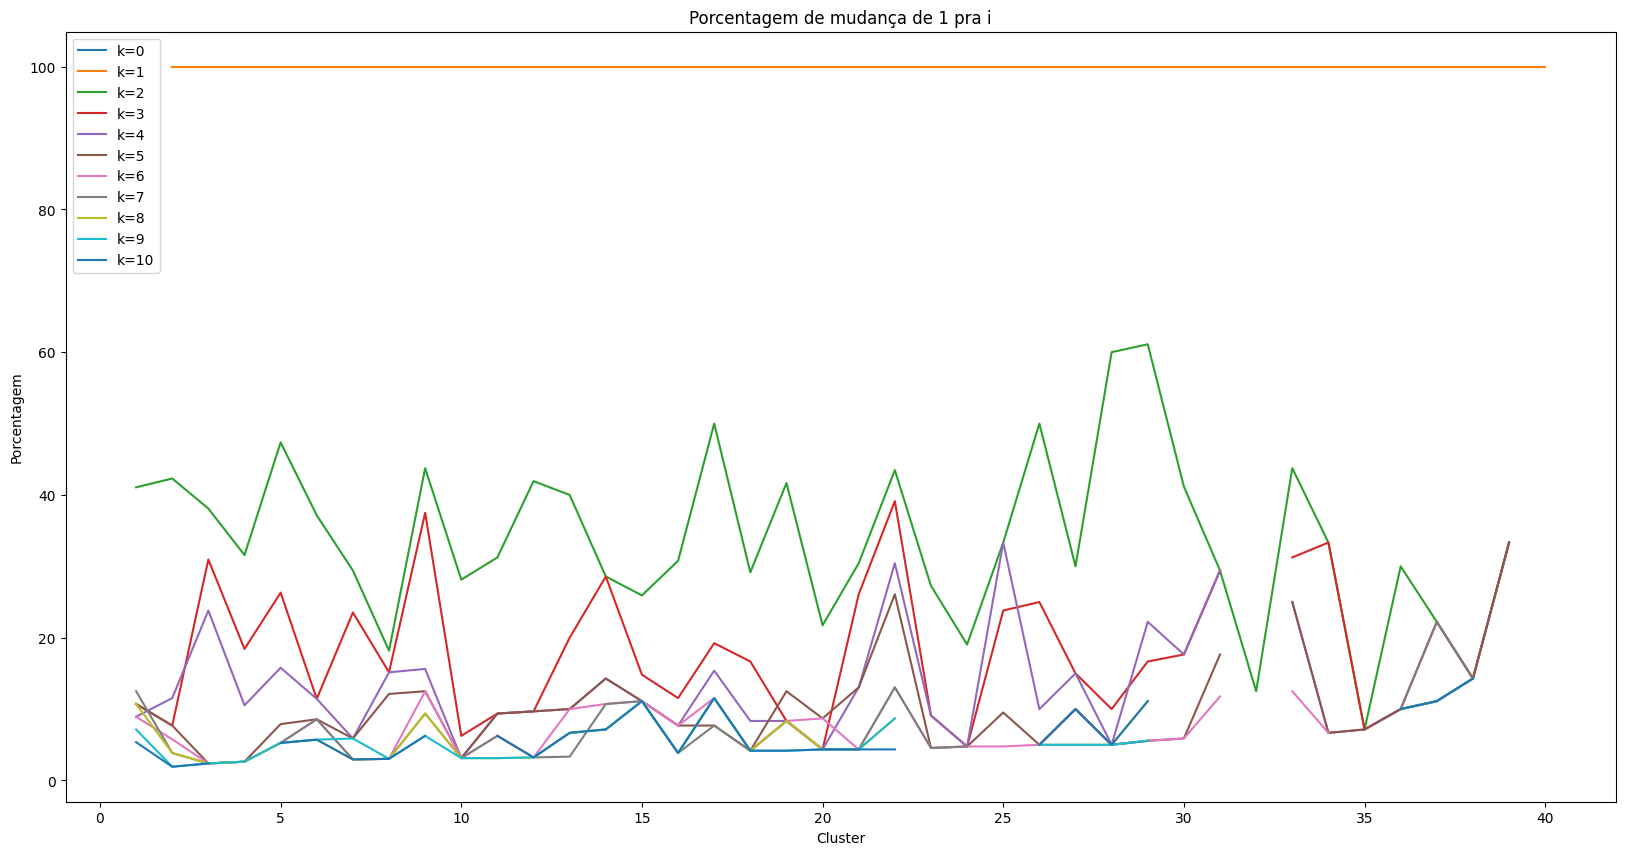

In [227]:
#Gerar graficos no formato abaixo


#Craia um novo df sem a primeira coluna de cada globals()['df_{}cluster_count'.format(i)]
for i in range(kNumber+1):
    globals()['df_{}cluster_countNew'.format(i)] = globals()['df_{}cluster_count'.format(i)].iloc[:, 1:]

#imprimir o dataframe
globals()['df_{}cluster_countNew'.format(9)]

#percorrer cada globals()['df_{}cluster_count'.format(i)], pegar a maior porcentagem de cada linha e salvar em um df exceto a primeira coluna
for i in range(kNumber+1):
    globals()['df_{}cluster_maior_porcentagem'.format(i)] = globals()['df_{}cluster_countNew'.format(i)].max(axis=1)

#imprimir o dataframe
globals()['df_{}cluster_maior_porcentagem'.format(9)]

#plotar um grafico de linha com a maior porcentagem de mudança por cluster
#plt.savefig('figure/cluster_change_porcentage.png')
#grafico deve conter todos os valores de globals()['df_{}cluster_maior_porcentagem'.format(i)] 

plt.figure(figsize=(20,10))
for i in range(kNumber+1):
    plt.plot(globals()['df_{}cluster_maior_porcentagem'.format(i)], label='k={}'.format(i))
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Porcentagem')
plt.title('Porcentagem de mudança de 1 pra i')
plt.savefig('figure/cluster_change_porcentage_1_to_i.png')


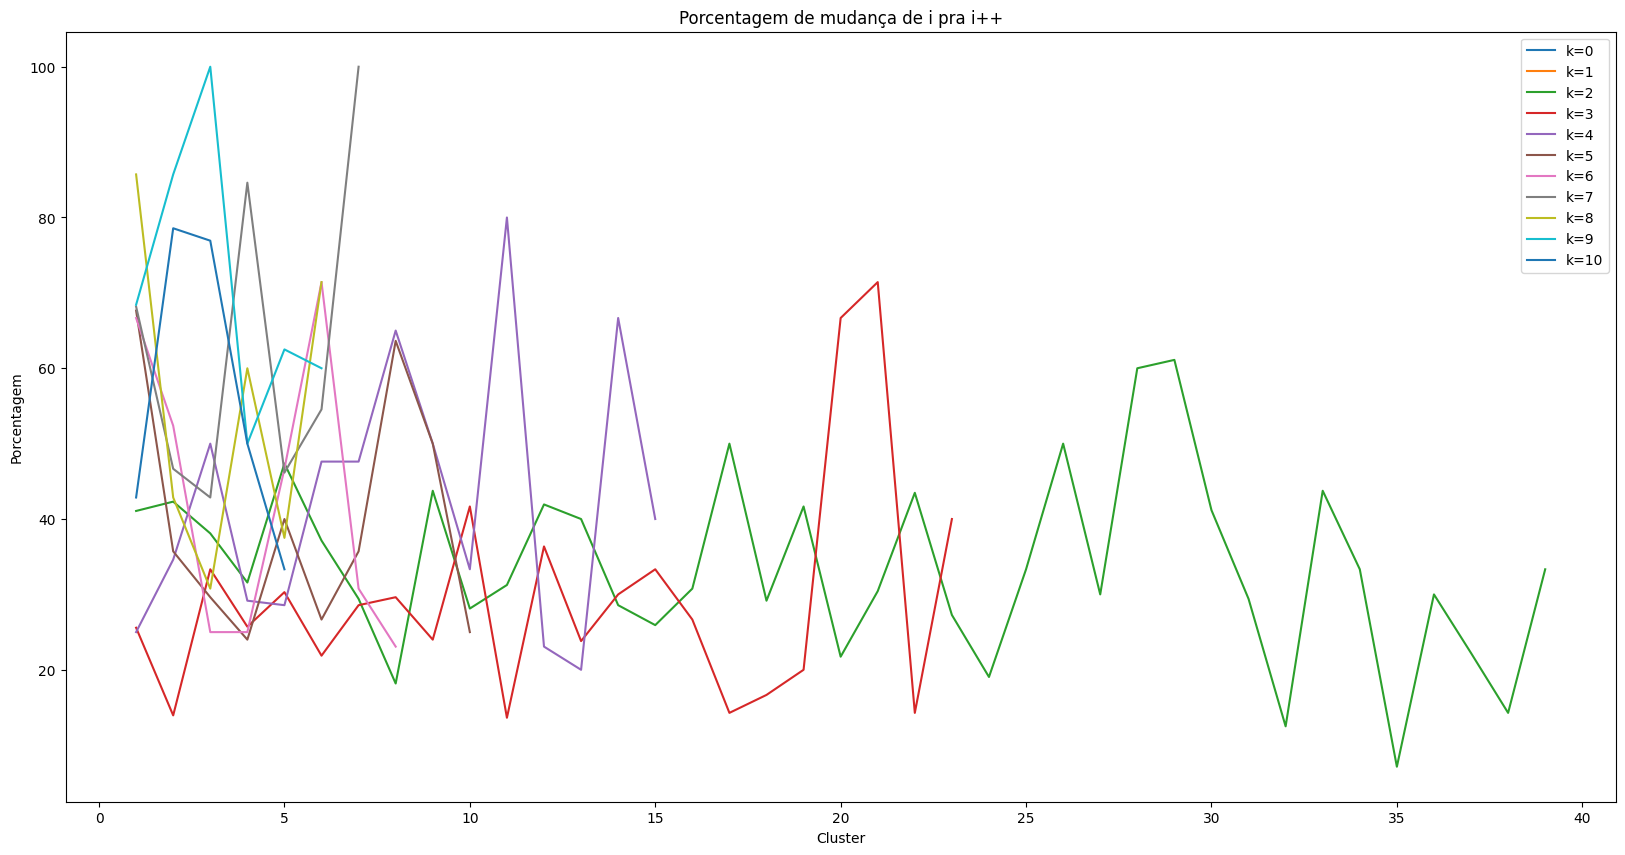

In [228]:
#Gerar graficos no formato abaixo
#Craia um novo df sem a primeira coluna de cada globals()['df_{}cluster_count'.format(i)]
for i in range(kNumber+1):
    globals()['df_{}cluster_countNew2'.format(i)] = globals()['df_{}cluster_count2'.format(i)].iloc[:, 1:]

#imprimir o dataframe
globals()['df_{}cluster_countNew2'.format(9)]

#percorrer cada globals()['df_{}cluster_count'.format(i)], pegar a maior porcentagem de cada linha e salvar em um df exceto a primeira coluna
for i in range(kNumber+1):
    globals()['df_{}cluster_maior_porcentagem2'.format(i)] = globals()['df_{}cluster_countNew2'.format(i)].max(axis=1)

#imprimir o dataframe
globals()['df_{}cluster_maior_porcentagem2'.format(9)]

#plotar um grafico de linha com a maior porcentagem de mudança por cluster
#plt.savefig('figure/cluster_change_porcentage.png')
#grafico deve conter todos os valores de globals()['df_{}cluster_maior_porcentagem'.format(i)] 

plt.figure(figsize=(20,10))
for i in range(kNumber+1):
    plt.plot(globals()['df_{}cluster_maior_porcentagem2'.format(i)], label='k={}'.format(i))
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Porcentagem')
plt.title('Porcentagem de mudança de i pra i++')
plt.savefig('figure/cluster_change_porcentage_i_to_i++.png')